In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [21]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose
from keras.constraints import max_norm
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adadelta

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [8]:
# Model configuration
img_width, img_height = 32, 32
batch_size = 32
no_epochs = 50
validation_split = 0.04
verbosity = 1
max_norm_value = 2.0
noise_factor = 0.25
number_of_visualizations = 10

In [9]:
x_train = x_train.reshape(x_train.shape[0],  img_width, img_height,3)
x_test = x_test.reshape(x_test.shape[0], img_width, img_height,3)
  

In [10]:
x_shape = (3 ,img_width, img_height)

In [11]:
# Parse numbers as floats
input_train = x_train.astype('float32')
input_test = x_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255


In [12]:
# Add noise
pure = input_train
pure_test = input_test
noise = np.random.normal(0, 1, pure.shape)
noise_test = np.random.normal(0, 1, pure_test.shape)
noisy_input = pure + noise_factor * noise
noisy_input_test = pure_test + noise_factor * noise_test

In [19]:
# Create the model
input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Flatten()(x)
x = Dense(3072)(x)
x = BatchNormalization()(x)
encoded = Activation('sigmoid')(x)

x = Dense(3072)(encoded)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Reshape((32,32,3))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [22]:

model = Model(input_img, decoded)
# model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0   

In [24]:
# Compile and fit data
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(noisy_input, pure,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)

Train on 48000 samples, validate on 2000 samples
Epoch 1/50
48000/48000 [==============================] - 77s 2ms/step - loss: 0.0114 - val_loss: 0.0074
Epoch 2/50
48000/48000 [==============================] - 69s 1ms/step - loss: 0.0080 - val_loss: 0.0067
Epoch 3/50
48000/48000 [==============================] - 69s 1ms/step - loss: 0.0072 - val_loss: 0.0062
Epoch 4/50
48000/48000 [==============================] - 69s 1ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 5/50
48000/48000 [==============================] - 68s 1ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 6/50
48000/48000 [==============================] - 68s 1ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 7/50
48000/48000 [==============================] - 68s 1ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 8/50
48000/48000 [==============================] - 68s 1ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 9/50
48000/48000 [==============================] - 70s 1ms/step - loss: 0.0052 - val_loss: 0.0059
Epoch 

In [25]:
score = model.evaluate(pure_test, noisy_input_test, verbose=1)
print(score)

10000/10000 [==============================] - 2s 213us/step
0.06873093332052231


In [ ]:
# Generate denoised images
samples = noisy_input_test[:number_of_visualizations]
targets = y_test[:number_of_visualizations]
denoised_images = model.predict(samples)

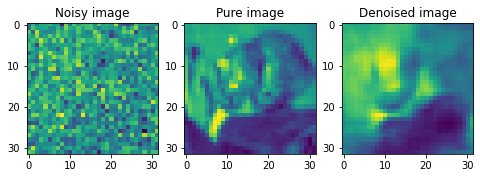

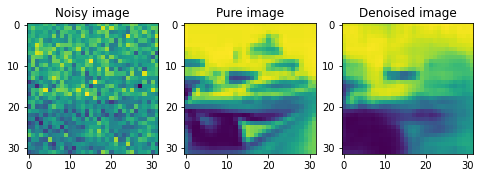

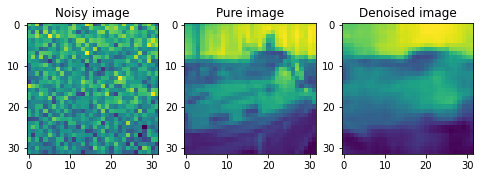

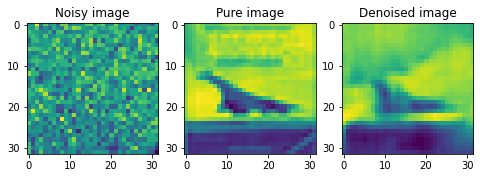

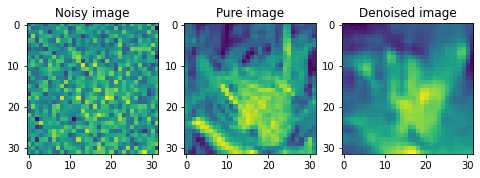

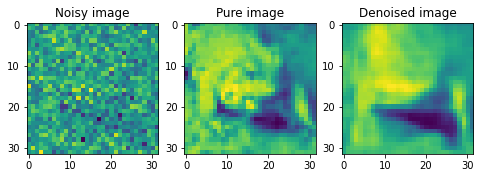

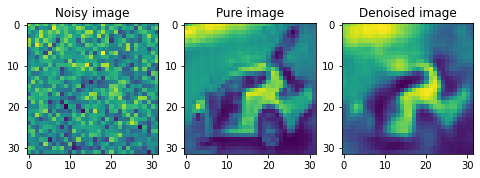

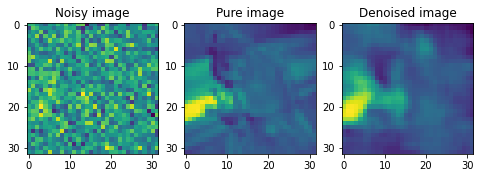

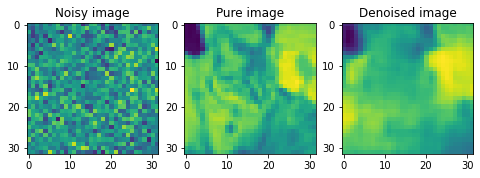

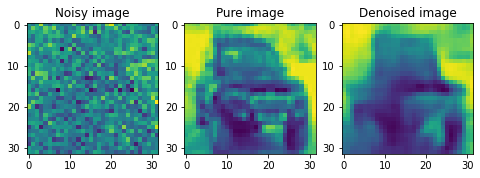

In [ ]:
# Plot denoised images
for i in range(0, number_of_visualizations):
  # Get the sample and the reconstruction
  noisy_image = noisy_input_test[i][:, :, 0]
  pure_image  = pure_test[i][:, :, 0]
  denoised_image = denoised_images[i][:, :, 0]
  input_class = targets[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(8, 3.5)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_image)
  axes[0].set_title('Noisy image')
  axes[1].imshow(pure_image)
  axes[1].set_title('Pure image')
  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image')
  
  plt.show()